In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb  1 17:31:47 2019

@author: Chris
"""
#import libraries
import numpy as np
import numpy.lib.recfunctions as rfn
from collections import OrderedDict, Counter
from sklearn.metrics import accuracy_score, precision_score
import itertools as it
from itertools import product
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import statistics
import datetime
import json
import re
import os
import sys

sys.path.append(r'C:\Users\micha\DS_7335_MWolfe\DeathToGridSearch')

import DeathToGridSearch
from DeathToGridSearch import *

#NumPy Cheatsheet - https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf


## HW notes:
'''
A medical claim is denoted by a claim number ('Claim.Number'). Each claim consists of one or more medical lines denoted by a claim line number ('Claim.Line.Number').

1. J-codes are procedure codes that start with the letter 'J'.

     A. Find the number of claim lines that have J-codes.

     B. How much was paid for J-codes to providers for 'in network' claims?

     C. What are the top five J-codes based on the payment to providers?



2. For the following exercises, determine the number of providers that were paid for at least one J-code. Use the J-code claims for these providers to complete the following exercises.

    A. Create a scatter plot that displays the number of unpaid claims (lines where the ‘Provider.Payment.Amount’ field is equal to zero) for each provider versus the number of paid claims.

    B. What insights can you suggest from the graph?

    C. Based on the graph, is the behavior of any of the providers concerning? Explain.



3. Consider all claim lines with a J-code.

     A. What percentage of J-code claim lines were unpaid?

     B. Create a model to predict when a J-code is unpaid. Explain why you choose the modeling approach.

     C. How accurate is your model at predicting unpaid claims?

      D. What data attributes are predominately influencing the rate of non-payment?
'''

"\nA medical claim is denoted by a claim number ('Claim.Number'). Each claim consists of one or more medical lines denoted by a claim line number ('Claim.Line.Number').\n\n1. J-codes are procedure codes that start with the letter 'J'.\n\n     A. Find the number of claim lines that have J-codes.\n\n     B. How much was paid for J-codes to providers for 'in network' claims?\n\n     C. What are the top five J-codes based on the payment to providers?\n\n\n\n2. For the following exercises, determine the number of providers that were paid for at least one J-code. Use the J-code claims for these providers to complete the following exercises.\n\n    A. Create a scatter plot that displays the number of unpaid claims (lines where the ‘Provider.Payment.Amount’ field is equal to zero) for each provider versus the number of paid claims.\n\n    B. What insights can you suggest from the graph?\n\n    C. Based on the graph, is the behavior of any of the providers concerning? Explain.\n\n\n\n3. Conside

V1,Claim.Number,Claim.Line.Number,Member.ID,Provider.ID,Line.Of.Business.ID,Revenue.Code,Service.Code,Place.Of.Service.Code,Procedure.Code,Diagnosis.Code,Claim.Charge.Amount,Denial.Reason.Code,Price.Index,In.Out.Of.Network,Reference.Index,Pricing.Index,Capitation.Index,Subscriber.Payment.Amount,Provider.Payment.Amount,Group.Index,Subscriber.Index,Subgroup.Index,Claim.Type,Claim.Subscriber.Type,Claim.Pre.Prince.Index,Claim.Current.Status,Network.ID,Agreement.ID

1,28849991,1,9583423,FA0001411002,2,128,RR8I, , ,V5789,19356.96, ,A,I,N,N,N,0,15036.21,110,7763000,0,M,H, ,2,P00000000002,FH001310QB01

There are 51029 claim lines that have J-Codes.
$2417220.96 was paid for J-codes to providers for in-network claims.
The top five J-codes based on payments to providers are: 
	 b'J1745'  : $ 434232.08
	 b'J0180'  : $ 299776.56
	 b'J9310'  : $ 168630.87
	 b'J3490'  : $ 90249.91
	 b'J1644'  : $ 81909.4
Scatterplot displaying number of unpaid versus paid claims is saved in working directory as Paidv

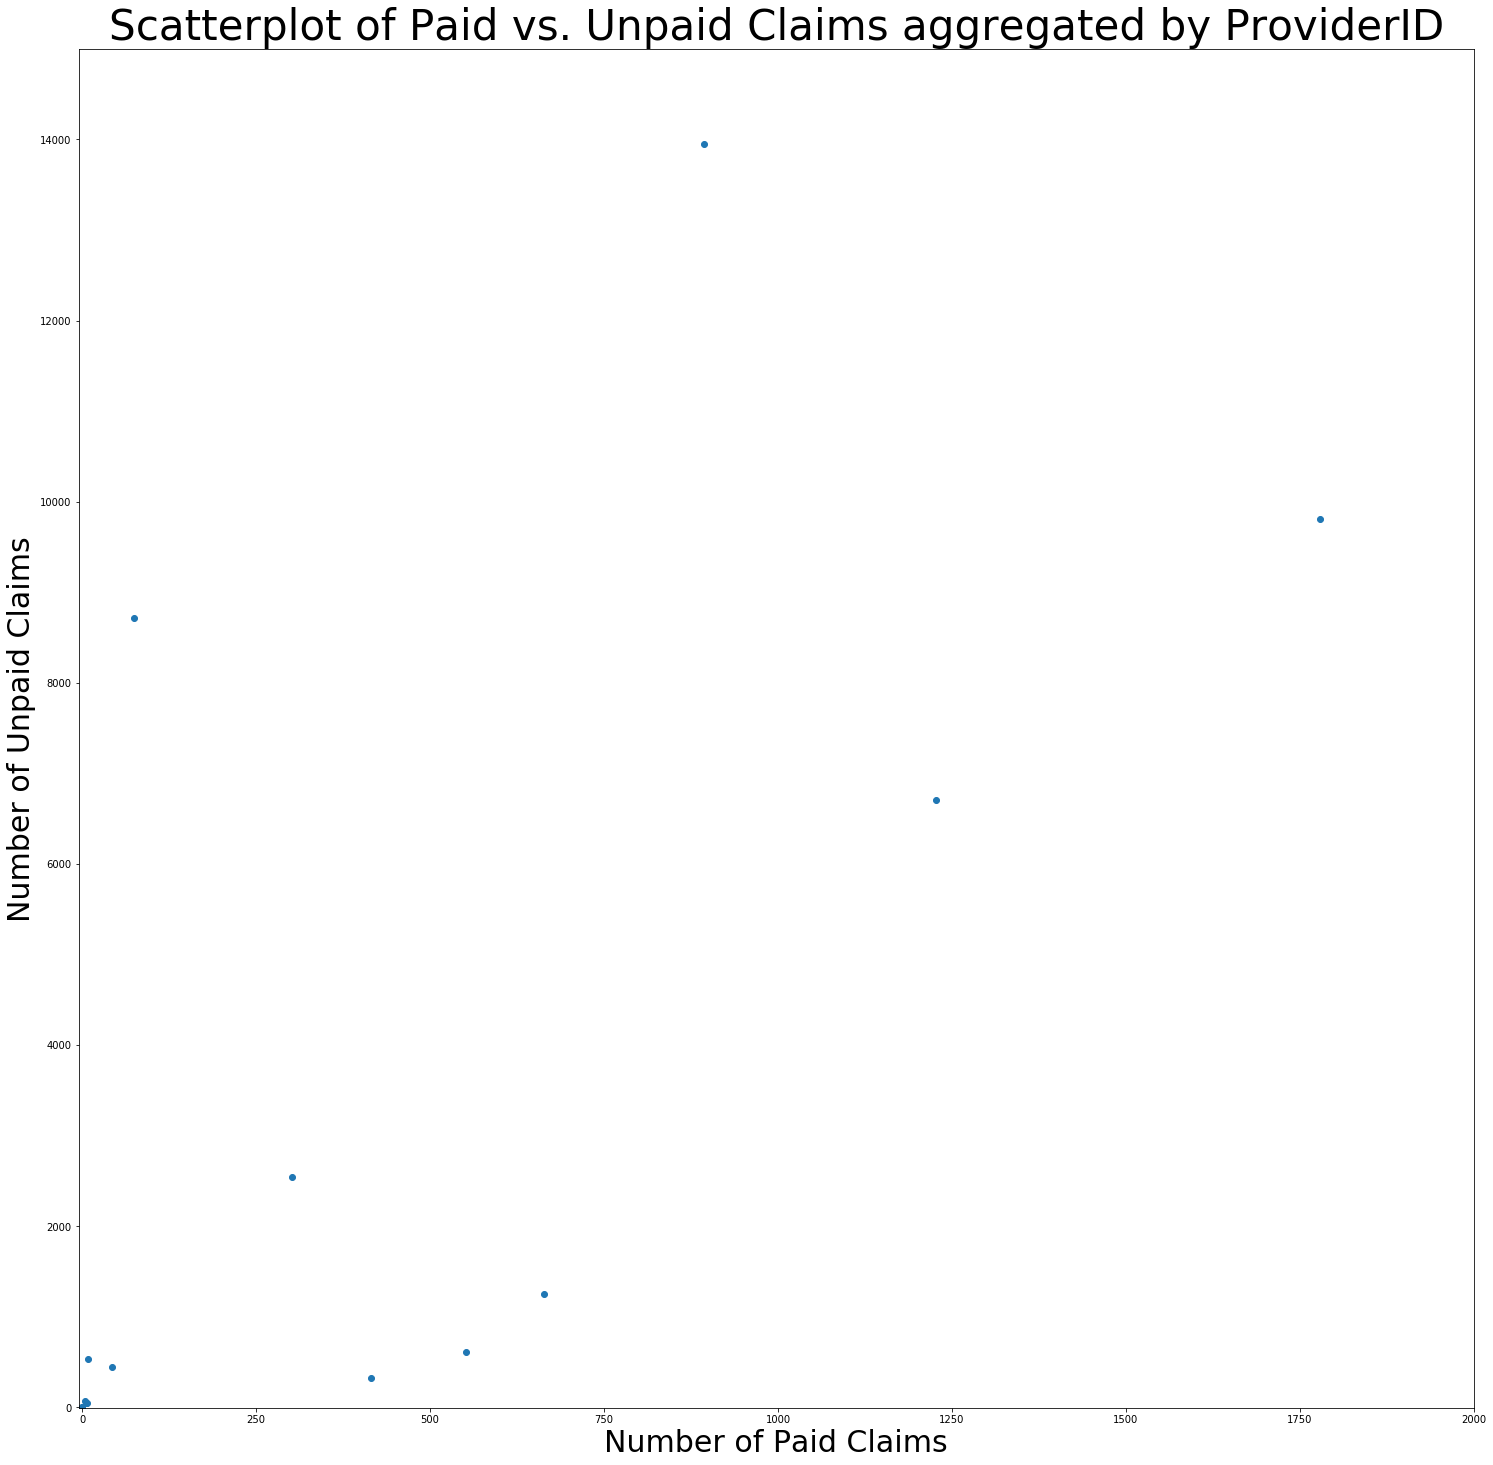

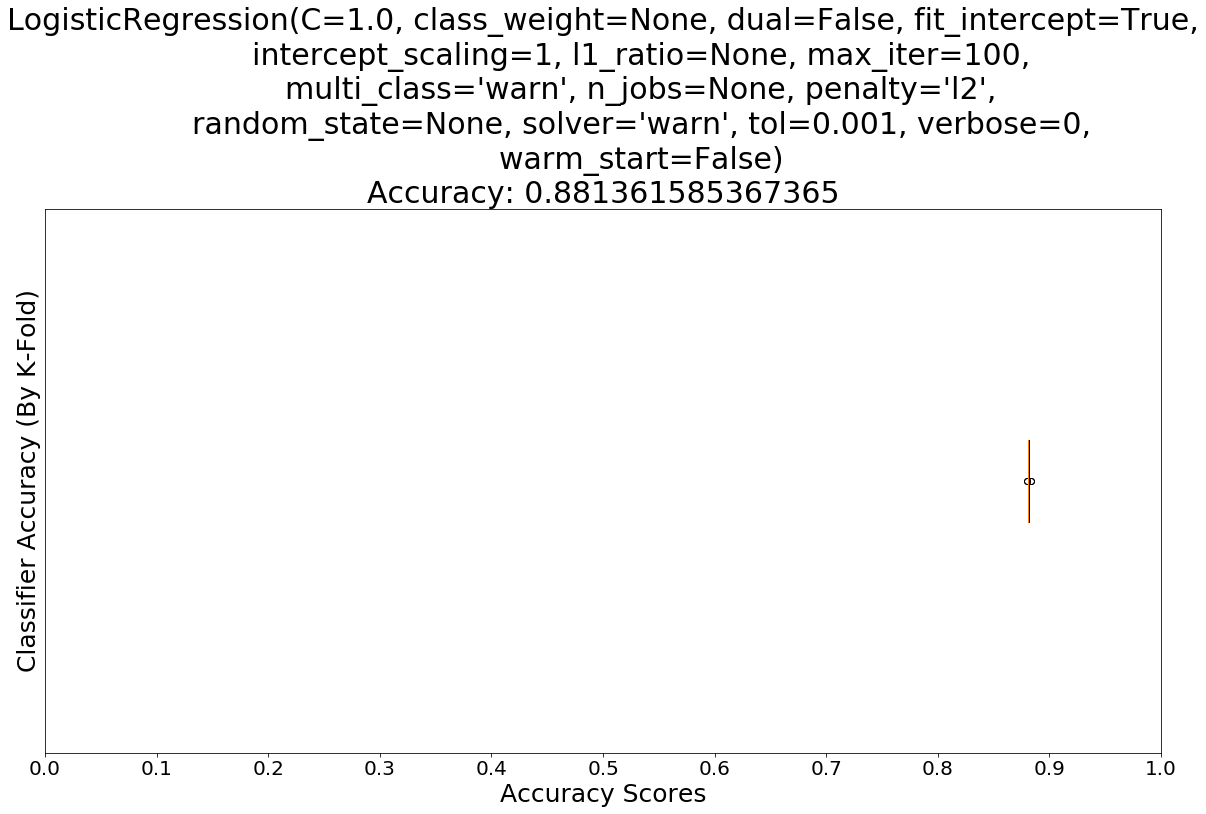


*Model with best accuracy:  0.881361585367365 
Classifier & Parameters: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
        intercept_scaling=1, l1_ratio=None, max_iter=100,
        multi_class='warn', n_jobs=None, penalty='l2',
        random_state=None, solver='warn', tol=0.001, verbose=0,
        warm_start=False) 
*


IndexError: index 1841 is out of bounds for axis 0 with size 1

<Figure size 432x288 with 0 Axes>

In [22]:
import numpy as np
import numpy.lib.recfunctions as rfn
from collections import OrderedDict, Counter
from sklearn.metrics import accuracy_score, precision_score
import itertools as it
from itertools import product
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import statistics
import datetime
import json
import re
import os
import sys

sys.path.append(r'C:\Users\micha\DS_7335_MWolfe\DeathToGridSearch')

from DeathToGridSearch import DeathToGridSearch


def get_JCodes_with_claims(data):
    JcodeIndicies = np.core.defchararray.startswith(data['ProcedureCode'], prefix = 'J'.encode(), start=0, end=1)
    Jcodes = data[JcodeIndicies]
    print("There are " + str(len(Jcodes)) + " claim lines that have J-Codes.")
    return Jcodes

def get_provider_amounts(data):
    JCodeInNet = data[data['InOutOfNetwork'] == 'I'.encode()]
    print("$"+str(round(sum(JCodeInNet['ProviderPaymentAmount']),2))+" was paid for J-codes to providers for in-network claims.")

def provider_payments(data, n_top_providers, payments_dict = {}):
    Sorted_Jcodes = np.sort(data, order='ProviderPaymentAmount')[::-1]
    JCodePayments = rfn.merge_arrays([Sorted_Jcodes['ProcedureCode'], Sorted_Jcodes['ProviderPaymentAmount']], flatten = True, usemask = False)
    for JCode in JCodePayments:
        if JCode[0] in payments_dict.keys():
            payments_dict[JCode[0]] += JCode[1]
        elif JCode[0] not in payments_dict.keys():
            payments_dict[JCode[0]] = JCode[1]
    JCodes_AggregatedPayments = OrderedDict(sorted(payments_dict.items(), key=lambda JCode: JCode[1], reverse=True))
    top_providers = list(JCodes_AggregatedPayments.items())[0:n_top_providers]
    print("The top five J-codes based on payments to providers are: ")
    for val in top_providers:
        print("\t", val[0]," : $", round(val[1],2))


def paid_vs_unpaid(paid, unpaid):
    filename = 'PaidvsUnpaid_Claims.png'
    NumProviders_PaidJCode = len(paid)
    paid_AGG = [paid[k] for k in unpaid.keys()]
    unpaid_AGG = [unpaid[k] for k in unpaid.keys()]
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    ax.scatter(paid_AGG, unpaid_AGG)
    ax.set_title("Scatterplot of Paid vs. Unpaid Claims aggregated by ProviderID", fontsize=42)
    ax.set_xlabel("Number of Paid Claims", fontsize=30)
    ax.set_ylabel("Number of Unpaid Claims", fontsize=30)
    ax.set_xlim(-5, 2000)
    ax.set_ylim(-5, 15000)

    try:
        plt.savefig(output_dir + '/' + filename, bbox_inches='tight')
    except IOError:
        os.mkdir(output_dir)
        plt.savefig(output_dir + '/' + filename, bbox_inches='tight')

    print(
        "Scatterplot displaying number of unpaid versus paid claims is saved in working directory as " + filename)
    print(
        "The graph suggests that there are many more unpaid J-code claims (45,057) than paid J-code claims (5,972). Note the different scales on the axes: y-axis (unpaid) is set to a max of 15,000 while x-axis (paid) is set to a max of 2,500 for better resolution. Scale of y-axis is 7.5x the scale of x-axis, which is approximately how many times greater the number of unpaid J-code claims is than the number of paid J-code claims")
    print(
        "The concerning behavior from the graph is that the number of unpaid claims are much greater than the number of paid claims. This suggests an overwhelming medical debt in this data population that is possibly looming over the entire healthcare industry. Healthcare providers will need to take significant steps to improve their claim collection process as this can be a major operational issue.")

    unpaid_pct = 0
    paid_pct = 0

    for row in Jcodes:
        if int(float(row[columnMap["ProviderPaymentAmount"]])) == 0:
            unpaid_pct += 1
        else:
            paid_pct += 1
    total = unpaid_pct + paid_pct
    percent_unpaid = float(unpaid_pct / total * 100)
    print("The percentage of unpaid J-code claim lines is: " + str(round(percent_unpaid, 2)) + '%')

output_dir = 'output' + '/'
output_dir_best = output_dir + 'BestResult'
output_dir_GridSearchResults = output_dir + '/' + 'CompleteResults'

with open('claim.sample.csv', 'r') as f:
    print(f.readline())
    print(f.readline())

names = ["V1","Claim.Number","Claim.Line.Number",
         "Member.ID","Provider.ID","Line.Of.Business.ID",
         "Revenue.Code","Service.Code","Place.Of.Service.Code",
         "Procedure.Code","Diagnosis.Code","Claim.Charge.Amount",
         "Denial.Reason.Code","Price.Index","In.Out.Of.Network",
         "Reference.Index","Pricing.Index","Capitation.Index",
         "Subscriber.Payment.Amount","Provider.Payment.Amount",
         "Group.Index","Subscriber.Index","Subgroup.Index",
         "Claim.Type","Claim.Subscriber.Type","Claim.Pre.Prince.Index",
         "Claim.Current.Status","Network.ID","Agreement.ID"]

types = ['S8', 'f8', 'i4', 'i4', 'S14', 'S6', 'S6', 'S6', 'S4', 'S9', 'S7', 'f8',
         'S5', 'S3', 'S3', 'S3', 'S3', 'S3', 'f8', 'f8', 'i4', 'i4', 'i4', 'S3',
         'S3', 'S3', 'S4', 'S14', 'S14']

CLAIMS = np.genfromtxt('claim.sample.csv', dtype=types, delimiter=',', names=True,
                       usecols=[0,1,2,3,4,5,
                                6,7,8,9,10,11,
                                12,13,14,15,16,
                                17,18,19,20,21,
                                22,23,24,25,26,
                                27,28])

Jcodes = get_JCodes_with_claims(CLAIMS)

get_provider_amounts(Jcodes)

provider_payments(Jcodes,5)

columns = CLAIMS.dtype.names
columnMap = {k:v for v, k in enumerate(columns)}
unpaid_claims = Counter()
paid_claims = Counter()

for row in Jcodes:
    if int(float(row[columnMap["ProviderPaymentAmount"]])) == 0:
        unpaid_claims[row[columnMap["ProviderID"]]] += 1
    else:
        paid_claims[row[columnMap["ProviderID"]]] += 1

paid_vs_unpaid(paid_claims,unpaid_claims)

model_cols = []
numeric_cols = ['SubscriberPaymentAmount', 'ClaimChargeAmount']
dummy_cols = {'ProviderID':{}, 'ServiceCode':{},'InOutOfNetwork':{},'NetworkID':{},'AgreementID':{}, 'DenialReasonCode':{}, 'PricingIndex':{}, 'ReferenceIndex':{}, 'ClaimPrePrinceIndex':{}, 'ClaimType':{},'ClaimSubscriberType':{}, 'ClaimCurrentStatus':{}, 'ProcedureCode':{}, 'RevenueCode':{}, 'DiagnosisCode':{}}
model_columns = []

for rownum, row in enumerate(Jcodes):
    for col in dummy_cols.keys():
        try:
            dummy_cols[col][rownum].add(row[columnMap[col]])
        except KeyError:
            dummy_cols[col][row[columnMap[col]]] = {rownum}
for colname, dumdict in dummy_cols.items():
    for dummy in dumdict.keys():
        model_columns.append("{}${}".format(colname, dummy.decode('UTF-8')))

classifierDict = {'RandomForestClassifier':{
    'min_samples_split': [2,3,5,6],
    'n_jobs': [3,5]},
    'LogisticRegression':{'tol': [0.001,0.0011,.005,.0055]},
          }

classifierList = {RandomForestClassifier,LogisticRegression,DecisionTreeClassifier}
clfList = {RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier}

model_df = []
for idx, row in enumerate(Jcodes):
    ith_row = []
    for colname in model_columns:
        col, val = colname.split("$")
        if idx in dummy_cols.get(col,val):
            ith_row.append(1)
        else:
            ith_row.append(0)
    for numeric in numeric_cols:
        ith_row.append(float(row[columnMap[numeric]]))

    if float(row[columnMap['ProviderPaymentAmount']]) > 0.0:
        ith_row.append(0.0)
    else:
        ith_row.append(1.0)
    model_df.append(ith_row)

for numeric_col in numeric_cols:
    model_columns.append(numeric_col)
np_df = np.array(model_df)

X = np_df[:, :-1]
y = np_df[:, -1]
n_folds = 5
data = (X,y,n_folds)


grid_search_classifiers = DeathToGridSearch(classifierDict,classifierList,data)

classifier_accuracy, importance_dict = grid_search_classifiers.run_gridsearch_classifiers()

best_classifier = grid_search_classifiers.get_best_score(classifier_accuracy)

grid_search_classifiers.plot_FeatureImportances(importance_dict,best_classifier,model_columns)

print("""Random Forest, Logistic Regression, and Decision Tree models were chosen to predict this binary classification task. Since I am familiar with some of the concepts in diagnosis codes but not with this specific healthcare system, I decided to test multiple approaches using my Gridsearch function from the previous assignment. Logistic Regression will perform well if the data is linearly separable and provides a simple model for the basis of comparison. Given the overwhelming amount of discrete/categorical variables compared to continuous/numeric variables in the data, I assume Decision Tree and Random Forest models will outperform Logistic Regression models in this classification task. \n\nThese three models will also provide parameters for interpretting the importance of features in the data that influence the classification decisions. Logistic Regression provides weights/coffieicents of the features from the resulting linear model. Decision Tree and Random Forest models provides actual feature importances calculated from the Gini Impurity metric (a measure of how often a randomly chosen instance from the data is misclassified). \n\nDue to the heavy class imbalance (88.3% unpaid claims), I used Stratified 5-Fold Cross Validation scheme to ensure that the class distribution was maintained in each fold.""")
        
print("""\nThe accuracy of the top performing classification model is listed below: 88.2% with a RandomForestClassifier. \nThe top 2 data attributes predominantly influencing the rate of non-payment are ClaimChargeAmount (0.999) and SubscriberPaymentAmount (0.00019468). \nThe bar chart visualizing the feature importances of data attributes influencing the classification of unpaid versus paid claims is saved in the working directory as "Feature_Importances+OptimalClf.png" and only displays the top 3 features since all other attributes besides the two mentioned above had a gini impurity of 0. This makes sense since larger claims will naturally be harder to pay. In future exercises it might be worthwhile to conduct ANOVA to determine more in-depth terms that contribute to both larger claims and payment defaults on said payments.""")

#This instantiation of gridsearch represents a gridsearch of nonclassification models, to test if any of those models could be more accurate than our
#classification models. It is not recommended to un-comment this as it will take a very long time to run.
#clfDict = {'RandomForestClassifier':{
#    'min_samples_split': [5,6],
#    'n_jobs': [3,5]},
#    'LogisticRegression':{'tol': [0.001,.0055]},
#    'KNeighborsClassifier': {
#        'n_neighbors': [20,30],
#        'algorithm': ['auto','ball_tree','brute'],
#        'p': [5]},
#    'QuadraticDiscriminantAnalysis':{'tol':[0.001,.0055],
#    'store_covariance':[False,True]},
#    'DecisionTreeClassifier':{'max_depth':[1,5]}
#          }
#accuracy_dict = grid_search.run_gridsearch()
#grid_search.get_best_score(accuracy_dict)
#grid_search = DeathToGridSearch(clfDict,clfList,data)



NameError: name 'filename' is not defined

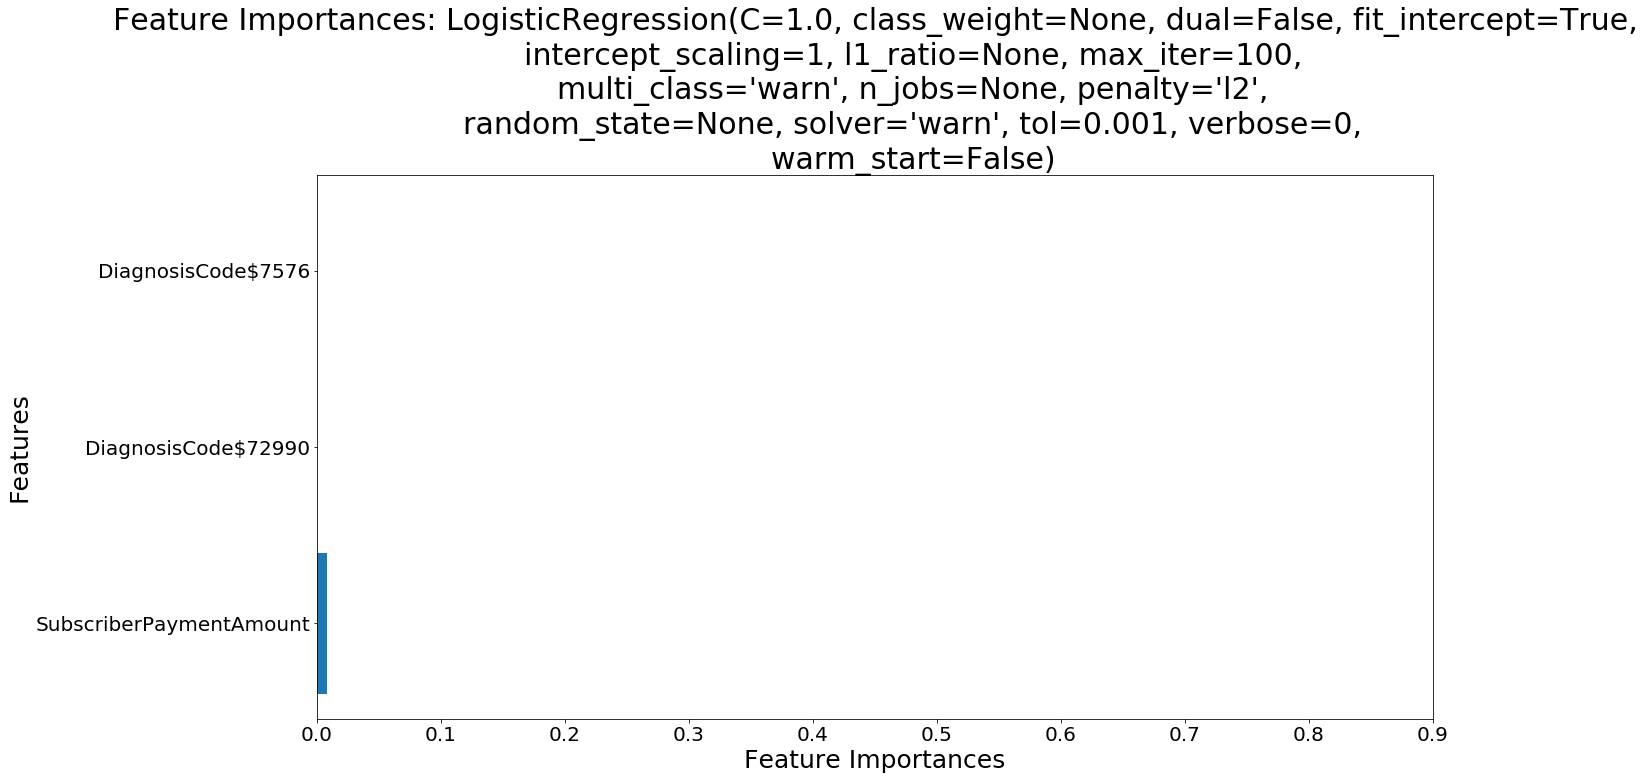

In [43]:
avgCV_FI = np.mean(importance_dict[best_classifier], axis=0)

# Plot only top 3 features from classifier
# I found only 2 features had actual values for feature importances: ClaimChargeAmount (0.999) and SubscriberPaymentAmount (0.00019468)
top3_featureIdx = avgCV_FI[0].argsort()[-3:][::-1]
top3_FI = avgCV_FI[0][top3_featureIdx]
top3_features = []
for i in top3_featureIdx:
    top3_features.append(model_columns[i])

# plt.barh(np.arange(len(top3_features)),top3_FI, align = 'center')
# plt.yticks(np.arange(len(top3_features)), top3_features)
# plt.xlabel('Feature Importances')
# plt.title("Feature Importances: " + str(classifier))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
plt.barh(np.arange(len(top3_features)), top3_FI, align='center')
ax.set_title("Feature Importances: " + str(best_classifier), fontsize=30)
ax.set_ylabel('Features', fontsize=25)
ax.set_xlabel('Feature Importances', fontsize=25)
ax.xaxis.set_ticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(len(top3_features)), top3_features)
# ax.yaxis.set_ticks(np.arange(min(avgCV_FI), max(avgCV_FI)+0.3, 0.1))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.savefig(output_dir + filename, bbox_inches='tight')
plt.show()

In [30]:
avgCV_FI = np.mean(importance_dict[best_classifier], axis=0)

# Plot only top 3 features from classifier
# I found only 2 features had actual values for feature importances: ClaimChargeAmount (0.999) and SubscriberPaymentAmount (0.00019468)
top3_featureIdx = avgCV_FI.argsort()[-3:][::-1]
top3_FI = avgCV_FI[0][top3_featureIdx]
top3_features = []

In [35]:
avgCV_FI[0].argsort()[-3:][::-1]

array([1840,  603,  605], dtype=int64)

In [2]:
#Read the two first two lines of the file.
with open('claim.sample.csv', 'r') as f:
    print(f.readline())
    print(f.readline())


#Colunn names that will be used in the below function, np.genfromtxt
names = ["V1","Claim.Number","Claim.Line.Number",
         "Member.ID","Provider.ID","Line.Of.Business.ID",
         "Revenue.Code","Service.Code","Place.Of.Service.Code",
         "Procedure.Code","Diagnosis.Code","Claim.Charge.Amount",
         "Denial.Reason.Code","Price.Index","In.Out.Of.Network",
         "Reference.Index","Pricing.Index","Capitation.Index",
         "Subscriber.Payment.Amount","Provider.Payment.Amount",
         "Group.Index","Subscriber.Index","Subgroup.Index",
         "Claim.Type","Claim.Subscriber.Type","Claim.Pre.Prince.Index",
         "Claim.Current.Status","Network.ID","Agreement.ID"]


#https://docs.scipy.org/doc/numpy-1.12.0/reference/arrays.dtypes.html
#These are the data types or dtypes that will be used in the below function, np.genfromtxt()
types = ['S8', 'f8', 'i4', 'i4', 'S14', 'S6', 'S6', 'S6', 'S4', 'S9', 'S7', 'f8',
         'S5', 'S3', 'S3', 'S3', 'S3', 'S3', 'f8', 'f8', 'i4', 'i4', 'i4', 'S3',
         'S3', 'S3', 'S4', 'S14', 'S14']


#NumPy Structured Arrays: https://docs.scipy.org/doc/numpy/user/basics.rec.html
# Though... I like this Structured Array explanation better in some cases: https://jakevdp.github.io/PythonDataScienceHandbook/02.09-structured-data-numpy.html
#np.genfromtxt:  https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

#read in the claims data into a structured numpy array
CLAIMS = np.genfromtxt('claim.sample.csv', dtype=types, delimiter=',', names=True,
                       usecols=[0,1,2,3,4,5,
                                6,7,8,9,10,11,
                                12,13,14,15,16,
                                17,18,19,20,21,
                                22,23,24,25,26,
                                27,28])

V1,Claim.Number,Claim.Line.Number,Member.ID,Provider.ID,Line.Of.Business.ID,Revenue.Code,Service.Code,Place.Of.Service.Code,Procedure.Code,Diagnosis.Code,Claim.Charge.Amount,Denial.Reason.Code,Price.Index,In.Out.Of.Network,Reference.Index,Pricing.Index,Capitation.Index,Subscriber.Payment.Amount,Provider.Payment.Amount,Group.Index,Subscriber.Index,Subgroup.Index,Claim.Type,Claim.Subscriber.Type,Claim.Pre.Prince.Index,Claim.Current.Status,Network.ID,Agreement.ID

1,28849991,1,9583423,FA0001411002,2,128,RR8I, , ,V5789,19356.96, ,A,I,N,N,N,0,15036.21,110,7763000,0,M,H, ,2,P00000000002,FH001310QB01



In [3]:
def get_JCodes_with_claims(data):
    JcodeIndicies = np.core.defchararray.startswith(data['ProcedureCode'], prefix = 'J'.encode(), start=0, end=1)
    Jcodes = data[JcodeIndicies] 
    print("There are " + str(len(Jcodes)) + " claim lines that have J-Codes.")
    return Jcodes

In [4]:
Jcodes = get_JCodes_with_claims(CLAIMS)
def get_provider_amounts(data):
    JCodeInNet = data[data['InOutOfNetwork'] == 'I'.encode()]
    #JcodeInNetRevenue = sum(JCodeInNet['ProviderPaymentAmount'])
    print("$"+str(round(sum(JCodeInNet['ProviderPaymentAmount']),2))+" was paid for J-codes to providers for in-network claims.")
get_provider_amounts(Jcodes)

There are 51029 claim lines that have J-Codes.
$2417220.96 was paid for J-codes to providers for in-network claims.


In [5]:
def provider_payments(data, n_top_providers, payments_dict = {}):
    Sorted_Jcodes = np.sort(data, order='ProviderPaymentAmount')[::-1]
    JCodePayments = rfn.merge_arrays([Sorted_Jcodes['ProcedureCode'], Sorted_Jcodes['ProviderPaymentAmount']], flatten = True, usemask = False)
    for JCode in JCodePayments:
        if JCode[0] in payments_dict.keys():
            payments_dict[JCode[0]] += JCode[1]
        elif JCode[0] not in payments_dict.keys():
            payments_dict[JCode[0]] = JCode[1]
    JCodes_AggregatedPayments = OrderedDict(sorted(payments_dict.items(), key=lambda JCode: JCode[1], reverse=True))
    top_providers = list(JCodes_AggregatedPayments.items())[0:n_top_providers]
    print("The top five J-codes based on payments to providers are: ")
    for val in top_providers:
        print("\t", val[0]," : $", round(val[1],2))
provider_payments(Jcodes,5)

The top five J-codes based on payments to providers are: 
	 b'J1745'  : $ 434232.08
	 b'J0180'  : $ 299776.56
	 b'J9310'  : $ 168630.87
	 b'J3490'  : $ 90249.91
	 b'J1644'  : $ 81909.4


Scatterplot displaying number of unpaid versus paid claims is saved in working directory as 'PaidvsUnpaid_Claims.png'.
The graph suggests that there are many more unpaid J-code claims (45,057) than paid J-code claims (5,972). Note the different scales on the axes: y-axis (unpaid) is set to a max of 15,000 while x-axis (paid) is set to a max of 2,500 for better resolution. Scale of y-axis is 7.5x the scale of x-axis, which is approximately how many times greater the number of unpaid J-code claims is than the number of paid J-code claims
The concerning behavior from the graph is that the number of unpaid claims are much greater than the number of paid claims. This suggests an overwhelming medical debt in this data population that is possibly looming over the entire healthcare industry. Healthcare providers will need to take significant steps to improve their claim collection process as this can be a major operational issue.
The percentage of unpaid J-code claim lines is: 88.3%


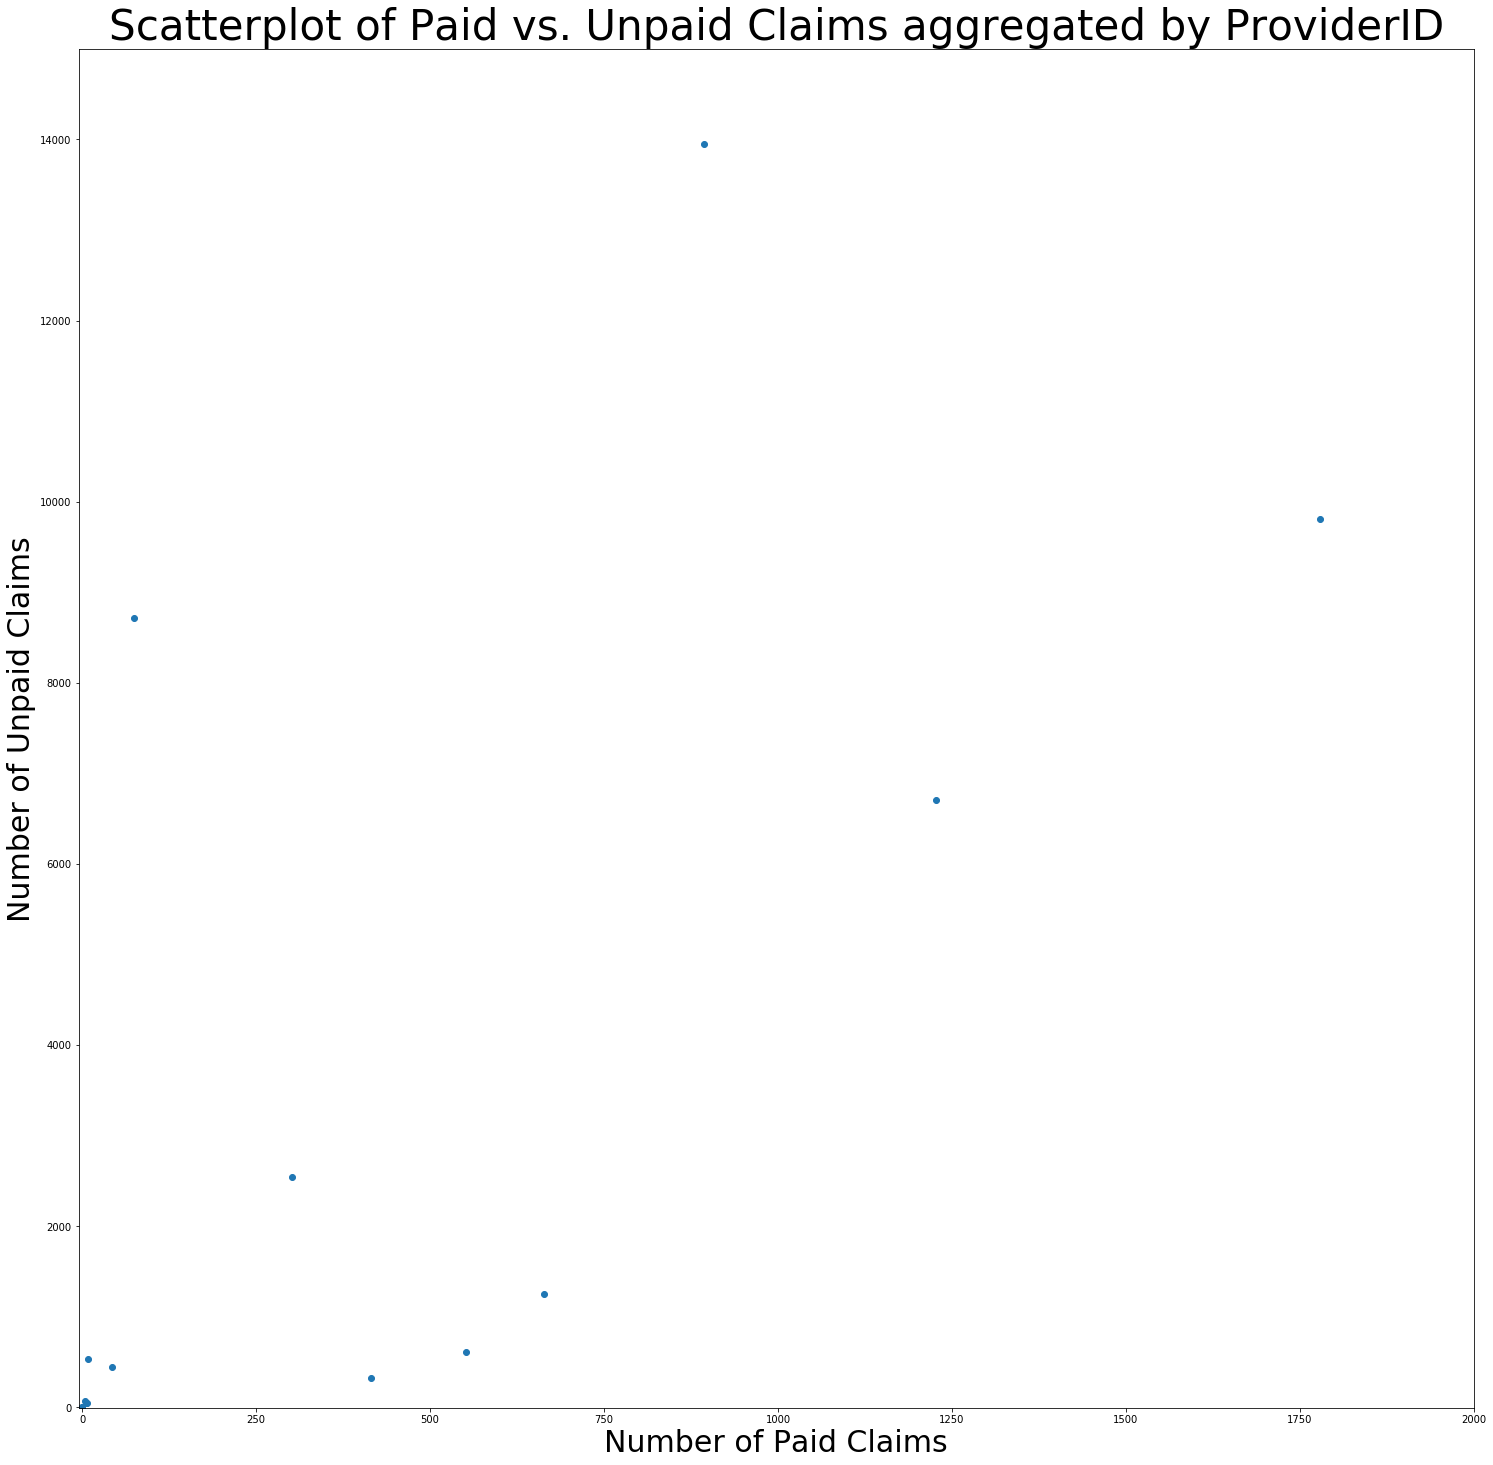

In [6]:
# 2A
columns = CLAIMS.dtype.names
columnMap = {k:v for v, k in enumerate(columns)}
unpaid_claims = Counter()
paid_claims = Counter()

for row in Jcodes:
    if int(float(row[columnMap["ProviderPaymentAmount"]])) == 0:
        unpaid_claims[row[columnMap["ProviderID"]]] += 1
    else:
        paid_claims[row[columnMap["ProviderID"]]] += 1
        
def paid_vs_unpaid(paid, unpaid):
    
    NumProviders_PaidJCode = len(paid)
    paid_AGG = [paid[k] for k in unpaid.keys()]
    unpaid_AGG = [unpaid[k] for k in unpaid.keys()]
    fig, ax = plt.subplots(1, 1, figsize = (25,25))
    ax.scatter(paid_AGG, unpaid_AGG)
    ax.set_title("Scatterplot of Paid vs. Unpaid Claims aggregated by ProviderID", fontsize = 42)
    ax.set_xlabel("Number of Paid Claims", fontsize = 30)
    ax.set_ylabel("Number of Unpaid Claims", fontsize = 30)
    ax.set_xlim(-5, 2000)
    ax.set_ylim(-5, 15000)

    try:
        fig.savefig("PaidvsUnpaid_Claims.png")
    except IOError:
        os.mkdir('figures')
        fig.savefig("PaidvsUnpaid_Claims.png")
            
    print("Scatterplot displaying number of unpaid versus paid claims is saved in working directory as 'PaidvsUnpaid_Claims.png'.")
    print("The graph suggests that there are many more unpaid J-code claims (45,057) than paid J-code claims (5,972). Note the different scales on the axes: y-axis (unpaid) is set to a max of 15,000 while x-axis (paid) is set to a max of 2,500 for better resolution. Scale of y-axis is 7.5x the scale of x-axis, which is approximately how many times greater the number of unpaid J-code claims is than the number of paid J-code claims")
    print("The concerning behavior from the graph is that the number of unpaid claims are much greater than the number of paid claims. This suggests an overwhelming medical debt in this data population that is possibly looming over the entire healthcare industry. Healthcare providers will need to take significant steps to improve their claim collection process as this can be a major operational issue.")
     

    unpaid_pct = 0
    paid_pct = 0
    
    for row in Jcodes:
        if int(float(row[columnMap["ProviderPaymentAmount"]])) == 0:
            unpaid_pct += 1
        else:
            paid_pct += 1
    total = unpaid_pct + paid_pct
    percent_unpaid = float(unpaid_pct/total * 100)
    print("The percentage of unpaid J-code claim lines is: " + str(round(percent_unpaid,2)) +'%')
    
paid_vs_unpaid(paid_claims,unpaid_claims)

In [8]:
model_cols = []
numeric_cols = ['SubscriberPaymentAmount', 'ClaimChargeAmount']
dummy_cols = {'ProviderID':{}, 'ServiceCode':{},'InOutOfNetwork':{},'NetworkID':{},'AgreementID':{}, 'DenialReasonCode':{}, 'PricingIndex':{}, 'ReferenceIndex':{}, 'ClaimPrePrinceIndex':{}, 'ClaimType':{},'ClaimSubscriberType':{}, 'ClaimCurrentStatus':{}, 'ProcedureCode':{}, 'RevenueCode':{}, 'DiagnosisCode':{}}
model_columns = []

for rownum, row in enumerate(Jcodes):
    for col in dummy_cols.keys():
        try:
            dummy_cols[col][rownum].add(row[columnMap[col]])
        except KeyError:
            dummy_cols[col][row[columnMap[col]]] = {rownum}
for colname, dumdict in dummy_cols.items():
    for dummy in dumdict.keys():
        model_columns.append("{}${}".format(colname, dummy.decode('UTF-8')))

model_df = []
for idx, row in enumerate(Jcodes):
    ith_row = []
    for colname in model_columns:
        col, val = colname.split("$")
        if idx in dummy_cols.get(col,val):
            ith_row.append(1)
        else:
            ith_row.append(0)
    for numeric in numeric_cols:
        ith_row.append(float(row[columnMap[numeric]]))

    if float(row[columnMap['ProviderPaymentAmount']]) > 0.0:
        ith_row.append(0.0)
    else:
        ith_row.append(1.0)
    model_df.append(ith_row)

for numeric_col in numeric_cols:
    model_columns.append(numeric_col)
np_df = np.array(model_df)

X = np_df[:, :-1]
y = np_df[:, -1]
n_folds = 5
data = (X,y,n_folds)

In [9]:
classifierDict = {'RandomForestClassifier':{
    'min_samples_split': [2,3,5,6],
    'n_jobs': [3,5]},
    'LogisticRegression':{'tol': [0.001,0.0011,.005,.0055]},
          }

clfDict = {'RandomForestClassifier':{
    'min_samples_split': [2,3,5,6],
    'n_jobs': [3,5]},
    'LogisticRegression':{'tol': [0.001,0.0011,.005,.0055]},
    'KNeighborsClassifier': {
        'n_neighbors': [20,21,22,23,25,30],
        'algorithm': ['auto','ball_tree','brute'],
        'p': [3,4,5]},
    'QuadraticDiscriminantAnalysis':{'tol':[0.001,0.0011,.005,.0055],
    'store_covariance':[False,True]},
    'DecisionTreeClassifier':{'max_depth':[1,2,3,4,5]}
          }

In [10]:
classifierList = {RandomForestClassifier,LogisticRegression,DecisionTreeClassifier}
clfList = {RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier,QuadraticDiscriminantAnalysis}

In [ ]:
# With sklearn
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
'''
['cold' 'cold' 'warm' 'cold' 'hot' 'hot' 'warm' 'cold' 'warm' 'hot']
[0 0 2 0 1 1 2 0 2 1]
'''
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)



# With Keras
data = [1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
from numpy import array
from numpy import argmax
import keras.utils
from keras.utils import to_categorical
# define example
data = [1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
data = array(data)
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)
# invert encoding
inverted = argmax(encoded[0])
print(inverted)


In [11]:
grid_search = DeathToGridSearch(clfDict,clfList,data)
grid_search_classifiers = DeathToGridSearch(classifierDict,classifierList,data)

In [12]:
grid_search.data

(array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
         592.201995],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
         118.83297 ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
         196.890405],
        ...,
        [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
         119.1292  ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          86.415   ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          84.56325 ]]), array([1., 1., 1., ..., 1., 1., 1.]), 5)

In [17]:
classifier_accuracy, importance_dict = grid_search_classifiers.run_gridsearch_classifiers()
accuracy_dict = grid_search.run_gridsearch()

MemoryError: 

In [16]:
grid_search.get_best_score(accuracy_dict)

NameError: name 'accuracy_dict' is not defined

In [ ]:
#print dtypes and field names
print(CLAIMS.dtype)

#Notice the shape differs since we're using structured arrays.
print(CLAIMS.shape)

#However, you can still subset it to get a specific row.
print(CLAIMS[0])

#Subset it to get a specific value.
print(CLAIMS[0][1])

#Get the names
print(CLAIMS.dtype.names)

#Subset into a column
print(CLAIMS['MemberID'])

#Subset into a column and a row value
print(CLAIMS[0]['MemberID'])


In [ ]:
#String Operations in NumPy - https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.char.html

#Sorting, Searching, and Counting in NumPy - https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.sort.html

# You might see issues here: https://stackoverflow.com/questions/23319266/using-numpy-genfromtxt-gives-typeerror-cant-convert-bytes-object-to-str-impl

# If you do, encode as a unicode byte object
#A test string
test = 'J'
test = test.encode()

#A test NumPy array of type string
testStrArray = np.array(['Ja','JA', 'naJ', 'na' ],dtype='S9')

#Showing what the original string array looks like
print('Original String Array: ', testStrArray)

#Now try using startswith()
Test1Indexes = np.core.defchararray.startswith(testStrArray, test, start=0, end=None)
testResult1 = testStrArray[Test1Indexes]

#Showing what the original subset string array looks like with startswith()
print('Subset String Array with startswith(): ', testResult1)

#Now try using find()
TestIndexes = np.flatnonzero(np.core.defchararray.find(testStrArray,test)!=-1)

testResult2 = testStrArray[TestIndexes]

#Showing what the original subset string array looks like with find()
print('Subset String Array with find(): ', testResult2)

#Try startswith() on CLAIMS
JcodeIndexes = np.flatnonzero(np.core.defchararray.startswith(CLAIMS['ProcedureCode'], test, start=0, end=1)!=-1)

np.set_printoptions(threshold=500, suppress=True)

#Using those indexes, subset CLAIMS to only Jcodes
Jcodes = CLAIMS[JcodeIndexes]

print(Jcodes)

In [ ]:
#Try find() on CLAIMS
JcodeIndexes = np.flatnonzero(np.core.defchararray.find(CLAIMS['ProcedureCode'], test, start=1, end=2)!=-1)

#Using those indexes, subset CLAIMS to only Jcodes
Jcodes = CLAIMS[JcodeIndexes]

print(Jcodes)

print(Jcodes.dtype.names)

#QUESTION: How do you find the number of claim lines that have J-codes with "Jcodes"?
#You can figure this out. :)

print("Number of claim lines with J-Codes: " + str(Jcodes.shape[0]))

#QUESTION: How much was paid for J-codes to providers for 'in network' claims?
#Give this a try on your own after viewing the example code below.


#Sorted Jcodes, by ProviderPaymentAmount
Sorted_Jcodes = np.sort(Jcodes, order='ProviderPaymentAmount')


# Reverse the sorted Jcodes (A.K.A. in descending order)
Sorted_Jcodes = Sorted_Jcodes[::-1]

In [ ]:
#Try startswith() on CLAIMS
JcodeIndexes = np.flatnonzero(np.core.defchararray.startswith(CLAIMS['ProcedureCode'], test, start=0, end=1)!=-1)

np.set_printoptions(threshold=500, suppress=True)

#Using those indexes, subset CLAIMS to only Jcodes
Jcodes = CLAIMS[JcodeIndexes]

print(Jcodes)

In [ ]:
# A. Find the number of claim lines that have J-codes.
print("Number of claim lines with J-Codes: " + str(Jcodes.shape[0]))

In [ ]:
# B. How much was paid for J-codes to providers for 'in network' claims?
Sorted_Jcodes = np.sort(Jcodes, order='ProviderPaymentAmount')
Sorted_Jcodes = Sorted_Jcodes[::-1]
ProviderPayments = Sorted_Jcodes['ProviderPaymentAmount']
Jcodes = Sorted_Jcodes['ProcedureCode']
Jcodes[:3]
ProviderPayments[:3]
arrays = [Jcodes, ProviderPayments]
Jcodes_with_ProviderPayments = rfn.merge_arrays(arrays, flatten = True, usemask = False)
print(Jcodes_with_ProviderPayments[:3])

Jcodes_with_ProviderPayments.shape

In [ ]:
## B. How much was paid for J-codes to providers for 'in network' claims?
JCode_dict = {}
for aJCode in Jcodes_with_ProviderPayments:
    if aJCode[0] in JCode_dict.keys():
        JCode_dict[aJCode[0]] += aJCode[1]
    else:
        aJCode[0] not in JCode_dict.keys()
        JCode_dict[aJCode[0]] = aJCode[1]
        
np.sum([v1 for k1,v1 in JCode_dict.items()])
#JCodes_PaymentsAgg_descending = OrderedDict(sorted(JCode_dict.items(), key=lambda aJCode: aJCode[1], reverse=True))
#print(JCodes_PaymentsAgg_descending)

In [ ]:
Jcodes['ProviderPaymentAmount']

In [ ]:
#A. Create a scatter plot that displays the number of unpaid claims (lines where the ‘Provider.Payment.Amount’ 
#field is equal to zero) for each provider versus the number of paid claims.
plotLabels = ['ProviderID1','ProviderIDN'] #etc


#Produce the scatterplot as the answer to 2a
fig, ax = plt.subplots()
ax.scatter(UNPAIDAGG, PAIDAGG)
ax.grid(linestyle='-', linewidth='0.75', color='red')

fig = plt.gcf()
fig.set_size_inches(25, 25)
plt.rcParams.update({'font.size': 28})

for i, txt in enumerate(plotLabels):
    ax.annotate(txt, (UNPAIDAGG[i], PAIDAGG[i]))

plt.tick_params(labelsize=35)
plt.xlabel('# of Unpaid claims', fontsize=35)

plt.ylabel('# of Paid claims', fontsize=35)

plt.title('Scatterplot of Unpaid and Paid claims by Provider', fontsize=45)
plt.savefig('Paid_Unpaid_Scatterplot.png')